In [1]:
import sys
import json
import yaml
import pathlib
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import PIL

from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image, to_tensor
from ml_collections import ConfigDict

sys.path.append("..")
from core.dataset import COCODatasetWithID
from core.config import save_config
from core.model import Model
from core.metrics import AccuracyLogger, IndividualScoreLogger


In [2]:
checkpoint = "../output/test/checkpoint_1.tar"
config = "../output/test/config.yaml"
test_annotations = "../debug/annotations.json"
test_imagedir = "../debug/images"

In [3]:
%%capture

with open(config) as f:
        cfg = ConfigDict(yaml.load(f, Loader=yaml.Loader))

if not hasattr(cfg, "num_classes"): # infer number of classes
        with open(cfg.annotations) as f:
            NUM_CLASSES = len(json.load(f)["categories"])
        cfg.num_classes = NUM_CLASSES

# load model
checkpoint = torch.load(checkpoint, map_location="cpu")
model = Model.from_config(cfg)
model.load_state_dict(checkpoint['model_state_dict'])
model.extended_output = True
model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

In [4]:
%%capture

normal_images = COCODatasetWithID(test_annotations, test_imagedir, image_size=(224,224))
input_images = COCODatasetWithID(test_annotations, test_imagedir, image_size=(224,224), normalize_means=[0.485, 0.456, 0.406], normalize_stds=[0.229, 0.224, 0.225])

In [5]:
image_index = 0

context_images, target_images, bbox, labels_cpu, annotation_ids = input_images[image_index]
_ , _, _, attention_map = model(context_images.unsqueeze(0), target_images.unsqueeze(0), bbox.unsqueeze(0))
attention_map = attention_map.detach().squeeze() # output dimension: (layers, context_tokens)

grid_size = int(np.sqrt(attention_map.size(-1)))
attention_map = attention_map.reshape(attention_map.size(0), grid_size, grid_size)

In [6]:
layer_visualization = []

for layer in range(attention_map.size(0)):
    grid_size = int(np.sqrt(attention_map.size(-1)))

    mask = attention_map[layer]
    mask = mask / mask.max() # normalize
    mask = to_tensor(to_pil_image(mask).resize((224,224)))

    layer_visualization.append(to_pil_image(mask * normal_images[image_index][0]))

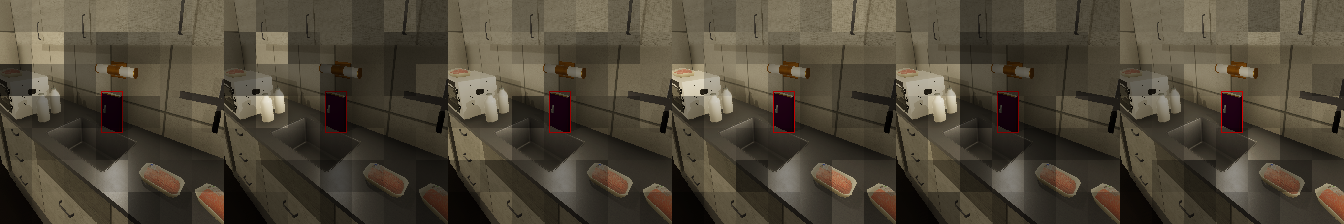

In [7]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid(layer_visualization, rows=1, cols=len(layer_visualization))